In [28]:
import numpy as np
import numpy.linalg as LA
import math
import matplotlib.pyplot as plt
import scipy.stats as s_stats

from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

import scipy.special as sp

from scipy.integrate import quad
from scipy.integrate import romberg

from tkinter import Tk
from tkinter import filedialog as fd

In [29]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [30]:
root = Tk()
filename = fd.askopenfilename(title = "Choose the mobility file")
#filenames = list(filenames_tuple)
f = open(filename,'r')

filename = fd.askopenfilename(title = "Choose the angle file")
g = open(filename,'r')
root.withdraw()

#read in mobilities
resistanceList = []
for line in f:
    newline = line.split()
    if is_number(newline[0][0]):
        #print(newline)
        resistanceList.append([float(newline[1]),float(newline[2])])  
        
#read in angles and bisection percentage
for counter, line in enumerate(g):
   newline = line.split()
   resistanceList[counter].append(float(newline[1]))
   resistanceList[counter].append(float(newline[2][1:-1]))


In [31]:
def mobilityVsAngleRaw(resistanceList):
    mobilities = np.asarray([i[0] for i in resistanceList])
    angles = np.asarray([180 - 2*abs(i[2]) for i in resistanceList])
    colors = np.random.rand(len(angles))
    plt.scatter(angles,mobilities,c = colors,alpha = 0.5)
    plt.xlabel("Boundary Angle Counterclockwise (degrees)")
    plt.ylabel("Mobility ($cm^{2}/Vs$)")
    plt.show()
    
#mobilityVsAngle(resistanceList)

def mobilityVsAngleNetworked(resistanceList):
    angles = np.asarray([i[2] for i in resistanceList])
    minAngle = np.min(angles)
    maxAngle = np.max(angles)
    stepSize = (maxAngle-minAngle)/20
    
    mobilityList = []
    mobilitySTDList = []
    
    angleArray = np.arange(minAngle,maxAngle,step=stepSize)
    
    for j in angleArray:
        currList = [i[0:2] for i in resistanceList if i[2] >= j and i[2] < j + stepSize]
        mobility, mobility_std = resistorNetwork(currList)
        mobilityList.append(mobility)
        mobilitySTDList.append(mobility_std)
        
    width      = 0.05
    plt.bar(np.add(angleArray,stepSize/2), np.asarray(mobilityList), width = 0.8*stepSize, color='c', yerr=np.asarray(mobilitySTDList))
    #plt.hist(angleArray,mobility,bins='fd',color='r')
    plt.xlabel("Angle")
    plt.ylabel("Mobility ($cm^{2}/Vs$)")
    plt.show()
    
#mobilityVsAngleNetworked(resistanceList)

In [32]:
def resistorNetwork(resistanceList):
    l = 7
    size = l**2 + 2
    n = .002*(10**21)
    e = 1.602*(10**(-19))

    R_total = []
    #r_cut = 1000
    r_cut = len(resistanceList)
    iterations = 2000

    for iterator in range(0,iterations):
        rIndex = np.random.randint(0,r_cut)
        R = 0

        C = np.zeros((size, size))
        D = np.zeros((size,size))
        over_count = 0

        #fill C_array
        for i in range(0,size - 1):
            for j in range(0,size - 1):
                if j == i:
                    over_r = 0
                else:
                    over_r = resistanceList[rIndex][0]

                #bottom node:
                if i==0 and j<= l and i!=j:
                    C[i][j] -= over_r
                    C[j][i] -= over_r

                    C[i][i] += over_r
                    C[j][j] += over_r

                    #rIndex += 1
                    rIndex = np.random.randint(0,r_cut)
                    
                    D[i][j] = 1
                    D[j][i] = 1

                #intermediate nodes
                if (j == i+1 and i%l != 0) or j == i + l:
                    if D[i][j] == 0:
                        C[i][j] -= over_r
                        C[j][i] -= over_r

                        C[i][i] += over_r
                        C[j][j] += over_r

                        #rIndex += 1
                        rIndex = np.random.randint(0,r_cut)
                        
                        D[i][j] = 1
                        D[j][i] = 1

                #top node
                if i >= size - l - 1:
                    if D[i][size - 1] == 0:
                        over_r = resistanceList[rIndex][0]

                        C[i][size - 1] -= over_r
                        C[size-1][i] -= over_r

                        C[i][i] += over_r
                        C[size-1][size-1] += over_r

                        #rIndex += 1
                        rIndex = np.random.randint(0,r_cut)
                        
                        D[i][size - 1] = 1
                        D[size-1][i] = 1
                        
            (w,v)=LA.eigh(C)   

        #count=0
        for i in range(0,size):
            if w[i] >= min(w):
                R+=(1/w[i])*np.abs(v[0][i]-v[size-1][i])**2

            #else:
            #    count+=1

                #print("Found zero eigenvalue, iterator is: %i"%iterator)

        R_total.append(R)

    R_total_array = np.asarray(R_total)
    #Mobility_total_array = np.asarray([1/(i*n*e) for i in R_total])
    Mobility_total_array = np.asarray([1/i for i in R_total])
    mean = R_total_array.mean()
    #median = R_total_array.median()
    std = np.std(R_total_array)
    
#     plt.hist(Mobility_total_array,bins = 40)
#     plt.xlabel("Resistor Network Value for Mobility ($cm^{2}/Vs$)")
#     plt.ylabel("Count")
#     plt.title("Distribution of Resistor Network Mobilities")
#     plt.show()


#     print("Resistance is: %f +- %f Ohms"%(mean,std))

    mobility = Mobility_total_array.mean()
    mobility_std = Mobility_total_array.std()
#     print("Mobility is: %f +- %f cm^2/Vs"%(mobility,mobility_std))
    
    return mobility, mobility_std
    
    #mobility_array.append([l,mobility,mobility_std])

#use kernal density estimation
#print(mobility_array)
#mobility = mobility_array[8][1]

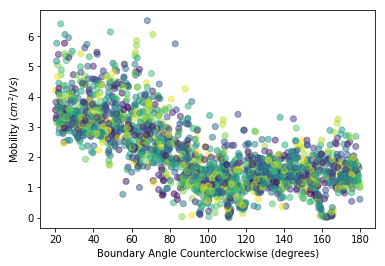

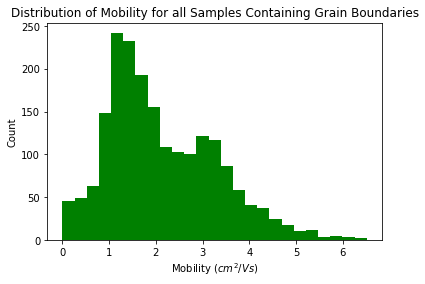

Resistor Network mobility mean is: 1.581860 +- 0.135961


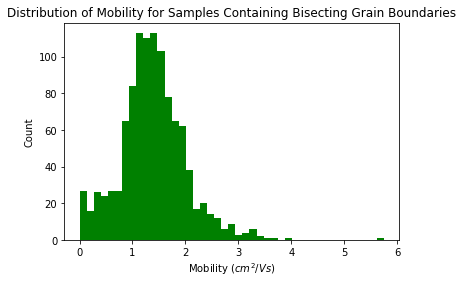

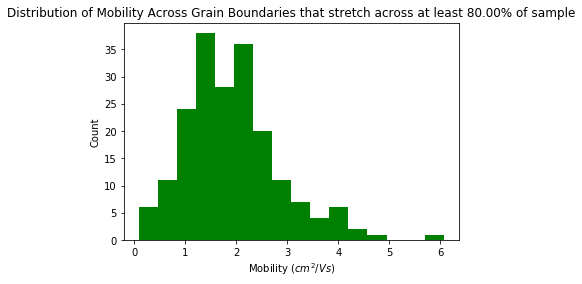

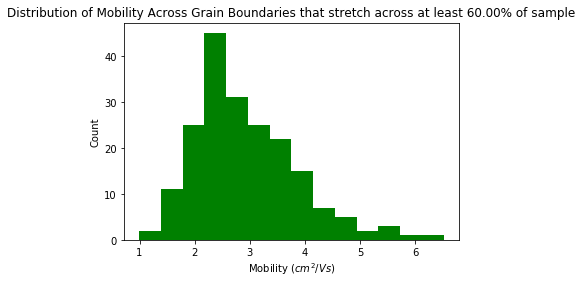

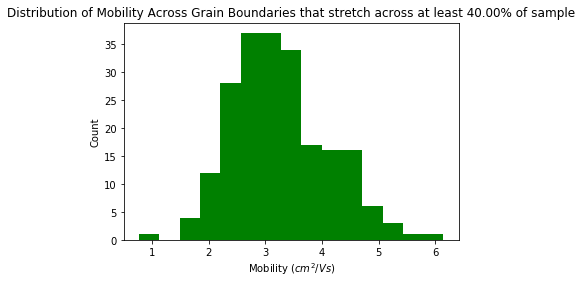

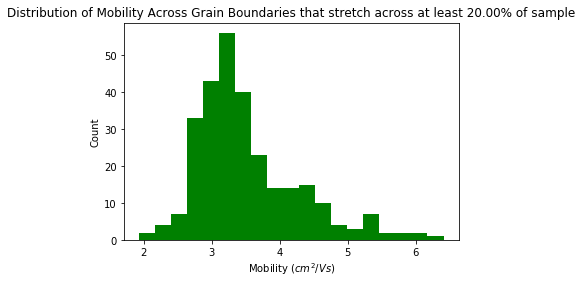

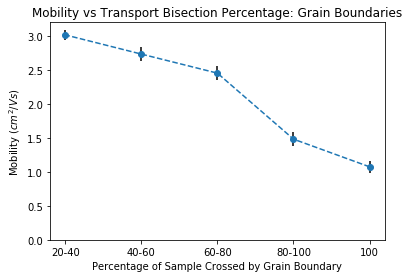

In [33]:
#mobility, mobility_std = resistorNetwork(resistanceList)
resistanceList = [i for i in resistanceList if i[0] > 0]
resistanceList = [i[:3] + [1] if i[3] > 1 else i for i in resistanceList]

mobilityVsAngleRaw(resistanceList)
#mobilityVsAngleNetworked(resistanceList)

#################
#plot histograms#
#################
mobilityList = []
mobilitySTDList = []
mobility, mobility_std = resistorNetwork(resistanceList)

#mobilityList.append(mobility)
#mobilitySTDList.append(mobility_std)

r_values = np.asarray([i[0] for i in resistanceList])
a_values = np.asarray([i[2] for i in resistanceList])

plt.hist(r_values,bins = 'fd',color='g')
plt.title('Distribution of Mobility for all Samples Containing Grain Boundaries')
plt.xlabel("Mobility ($cm^{2}/Vs$)")
plt.ylabel('Count')
plt.show()

print("Resistor Network mobility mean is: %f +- %f"%(mobility, mobility_std))

bisectList = [i[0:2] for i in resistanceList if i[3] >= 0.995]
mobility, mobility_std = resistorNetwork(bisectList)
mobilityList.append(mobility)
mobilitySTDList.append(mobility_std)
r_b_values = np.asarray([i[0] for i in bisectList])
plt.hist(r_b_values,bins = 'fd',color='g')
plt.title('Distribution of Mobility for Samples Containing Bisecting Grain Boundaries')
plt.xlabel("Mobility ($cm^{2}/Vs$)")
plt.ylabel('Count')
plt.show()

jList = []
j = 1.0
jList.append(100*(1-j))
step_size = 0.2
while j > step_size+.05:
    currList = [i[0:2] for i in resistanceList if i[3] >= j - step_size and i[3] < j]
    mobility, mobility_std = resistorNetwork(currList)
    mobilityList.append(mobility)
    mobilitySTDList.append(mobility_std)
    r_b_values = np.asarray([i[0] for i in currList])
    plt.hist(r_b_values,bins = 'fd',color='g')
    plt.title('Distribution of Mobility Across Grain Boundaries that stretch across at least %2.2f%% of sample'%((j-step_size)*100))
    plt.xlabel("Mobility ($cm^{2}/Vs$)")
    plt.ylabel('Count')
    plt.show()
    
    j -= step_size
    jList.append(100*(1-j))
    
jArray = np.asarray(jList)
linSize = len(mobilityList)
plt.errorbar(np.subtract(100.0,jArray),mobilityList,xerr = None, yerr = np.asarray(mobilitySTDList),linestyle = '--',marker = 'o',ecolor='black')
plt.xlabel("Percentage of Sample Crossed by Grain Boundary")
plt.ylabel("Mobility ($cm^{2}/Vs$)")
plt.ylim(bottom=0)
labels = ('20-40','40-60','60-80','80-100','100')
plt.xticks(np.arange(20,120,step=20),labels)
plt.title("Mobility vs Transport Bisection Percentage: Grain Boundaries")
plt.show()

In [34]:
mylist = [[0,1,2,1.1],[3,4,5,0.9],[6,7,8,.99]]
mynewlist = [i[:3] + [1] if i[3] > 1 else i for i in mylist]
print(mynewlist)

[[0, 1, 2, 1], [3, 4, 5, 0.9], [6, 7, 8, 0.99]]
